## 2. Image Registration with ORB detector

In [1]:
import numpy as np
import cv2
import glob
import tifffile
import os
import matplotlib.pyplot as plt
from pathlib import Path

## 2.1. Load data files
- hsi : uncropped jpg file generated from HSI source
- dmc : low-res RGB jpg file

In [2]:
base_path = '/storage/jgjang/J1_JeonGok/' 
tif_list = sorted(glob.glob(f'{base_path}/DMC/*.tif'))
jpg_list = sorted(glob.glob(f'{base_path}/DMC/*.jpg'))
hsimage_list= sorted(glob.glob(f'{base_path}/HSIs/*.jpg'))
Plot_fig=True

In [3]:
hsi_ind = 2
dmc_ind = 1

In [4]:
# plt.imshow(hsi[:,:,2::-1])
# plt.title('hyperspectral image')
# plt.show()
# plt.imshow(dmc[:,:,2::-1])
# plt.title('optical RGB image')
# plt.show()

In [5]:
def get_match(img1, img2):
    orb=cv2.ORB_create(
        nfeatures=10000,
    )
    kpA, desA = orb.detectAndCompute(img1,None)
    kpB, desB = orb.detectAndCompute(img2,None)
    
    bf =cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches=bf.match(desA,desB)
    no_of_matches = (len(matches))
    sorted_matches = sorted(matches,key = lambda x : x.distance)
    # res = cv2.drawMatches(img1, kpA, img2, kpB, sorted_matches[:5000], cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    src = np.float32([kpA[m.queryIdx].pt for m in matches]).reshape((-1,2))
    dst = np.float32([kpB[m.trainIdx].pt for m in matches]).reshape((-1,2))
    H, status = cv2.findHomography(src,dst, cv2.RANSAC)
    # print(res[0,0,:])
    # res[res==0]=255
    # res[res==14] = 255
    # res[res==15] = 255
    # res[res==16] = 255
    # res[res==17] = 255
    # res[res==18] = 255
    # cv2.imwrite('/storage/jgjang/feature.jpg', res)
    
    return H, no_of_matches

In [6]:
def img_Contrast(img, clip, grd_size):
    # -----Converting image to LAB Color model-----------------------------------
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # -----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)

    # -----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(grd_size,grd_size))
    cl = clahe.apply(l)

    # -----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl, a, b))

    # -----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return final

In [7]:
# hsi_copy = hsi.copy()
# for i in range(4):
#     hsi_copy = img_Contrast(hsi_copy)
#     img_1 = cv2.cvtColor(hsi_copy, cv2.COLOR_BGR2GRAY)
#     plt.imshow(img_1)
#     plt.show()

In [8]:
hsi_name = hsimage_list[hsi_ind]
jpg_name = jpg_list[dmc_ind]
hsi = cv2.imread(f'{hsi_name}')
dmc = cv2.imread(f'{jpg_name}')

height = hsi.shape[0]
width = hsi.shape[1]

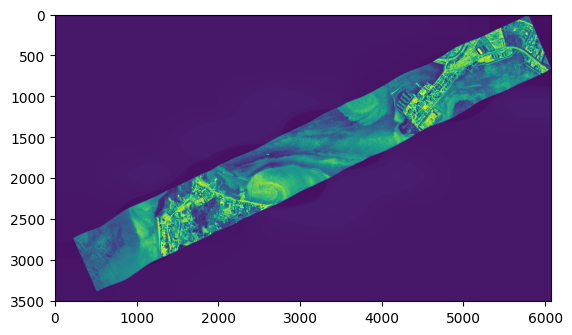

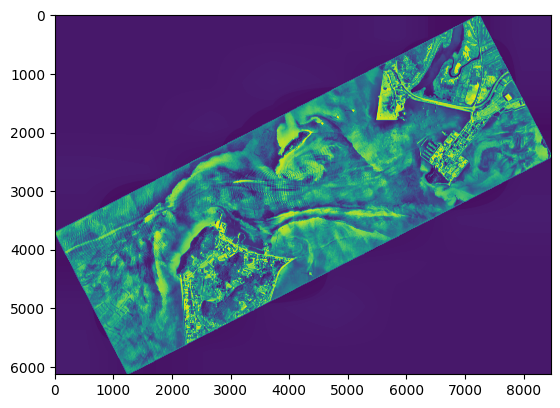

In [9]:
# dmc[dmc.mean(axis=2)==255,:]=0
dmc[dmc==255]=0
for i in range(2):
    dmc = img_Contrast(dmc, clip = 5.0, grd_size = 8)
for i in range(2):
    hsi = img_Contrast(hsi, clip = 5.0, grd_size = 8)
img_1 = cv2.cvtColor(hsi, cv2.COLOR_BGR2GRAY)
img_2 = cv2.cvtColor(dmc, cv2.COLOR_BGR2GRAY) 
#img_2[img_2>=255]=0
plt.imshow(img_1)
plt.show()
plt.imshow(img_2)
plt.show()



In [10]:
H, no_of_matches = get_match(img_2, img_1)

print(H)
print(no_of_matches)
# H = np.linalg.inv(H)

[[ 6.95130232e-01 -9.68074674e-03 -1.89308066e+02]
 [ 1.91684789e-02  7.05766069e-01 -6.93908745e+02]
 [-1.10343494e-06 -1.07879137e-06  1.00000000e+00]]
3218


In [11]:
transformed_img = cv2.warpPerspective(dmc, H, (width, height))

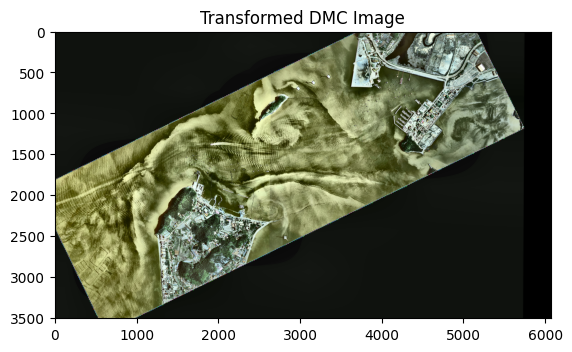

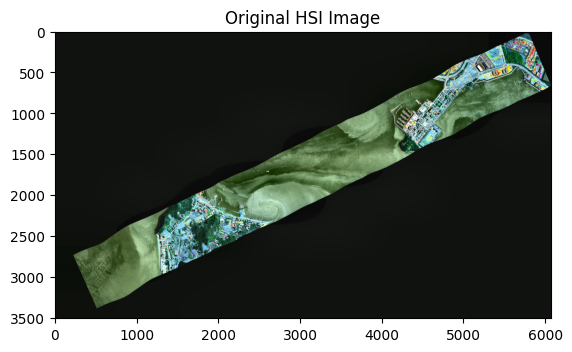

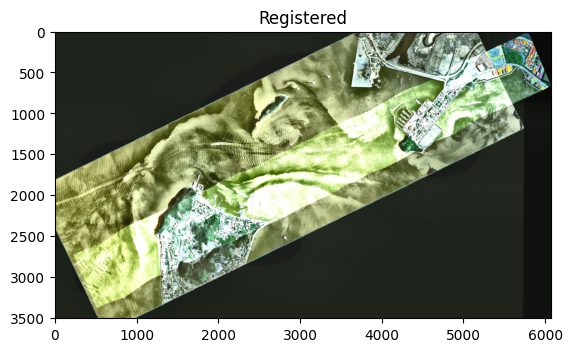

True

In [12]:
plt.imshow(transformed_img)
plt.title('Transformed DMC Image')
plt.show()
plt.imshow(hsi)
plt.title('Original HSI Image')
plt.show()
plt.imshow(cv2.add(hsi, transformed_img))
plt.title('Registered')
plt.show()
cv2.imwrite('/storage/jgjang/example_hsi.jpg', hsi)
cv2.imwrite('/storage/jgjang/example_dmc.jpg', transformed_img)
cv2.imwrite('/storage/jgjang/example.jpg', cv2.add(hsi, transformed_img))


## 2.2. Save Image and Crop (HSI)
Save the cropped HSI and RGB data into `data_save` folder
1. From the above registered image, we cute the image by 224x224 strides.
2. Save Cropped RGB image and HSI image 

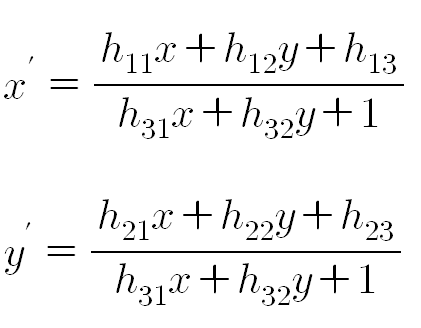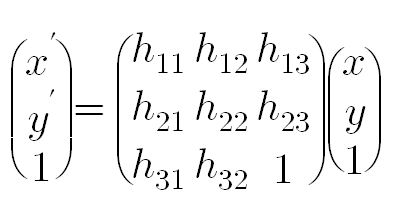

### 2.2.1. Import Packages and functions

In [13]:
import spectral.io.envi as envi
import numpy as np
import cv2
import glob
import skimage
import matplotlib.pyplot as plt
import tifffile
from itertools import product
import scipy.io as sio
from tqdm import tqdm
from spectral import *

In [14]:
Path = base_path + '/data_save_v2'
if not os.path.exists(Path):
    os.mkdir(Path)

In [15]:
from PIL import Image, ImageEnhance

def enhancer(img):
    PIL_img = Image.fromarray(img)
    out = ImageEnhance.Brightness(PIL_img).enhance(1.6)
    #out = ImageEnhance.Contrast(out).enhance(0.7)
    #out = ImageEnhance.Color(out).enhance(0.6)
    out = ImageEnhance.Sharpness(out).enhance(2.2)
    out = np.array(out)
    return out

def HSItensor2imgs(img):
    img = (255*img/ 0.235).astype(np.uint8)
    idx = [17,34,53]
    return enhancer(img[:,:,idx])

In [16]:
base_ratio= 7
def convert_axis(tif, H, col, row, stride, ratio):
    width = int(200 + ratio * stride * 2**0.5 )
    height = width
    palate = np.zeros((width,height,3), dtype=np.uint8)
    center_hsi =  [[row+stride/2], [col+stride/2], [1]]
    center_low_res_tif = np.matmul(np.linalg.inv(H),center_hsi)
    center_low_res_tif = center_low_res_tif[0:2,0]/center_low_res_tif[2,0]
    
    center_high_res_tif = center_low_res_tif * base_ratio
    st = [int(center_high_res_tif[0] - width/2), int(center_high_res_tif[1] - height/2)] 
    ed = [st[0]+width, st[1]+height] 
    st = st[2::-1]
    ed = ed[2::-1]
    if st[0] < tif.shape[0] and ed[0] >0 and st[1] < tif.shape[1] and ed[1]>0:
        palate[max(-st[0], 0): min(width,tif.shape[0]-st[0]), max(-st[1],0):min(height,tif.shape[1]-st[1]), :] = tif[max(st[0],0):ed[0], max(st[1],0):ed[1],:]
    # palate = palate.astype(np.uint8)
    palate[palate.mean(axis=2)==255,:] = 0
    return palate, st, ed

In [17]:
ratio = base_ratio / min(H[0,0], H[1,1])
from PIL import Image
stride = 224
def save_file(hsi_arr, tif, H):
    v_num = int(hsi_arr.shape[0]/stride)
    h_num = int(hsi_arr.shape[1]/stride)
    hsi_jpg = HSItensor2imgs(hsi_arr)
    ndvi_map = ndvi(hsi_arr + 1e-5,50,86)
    ndvi_map = np.floor(255* ndvi_map / np.max(ndvi_map)).astype(int)

    for im_idx, (v_ind, h_ind) in tqdm(enumerate(product(range(v_num), range(h_num)))):
        
        v_st = v_ind * stride; v_ed = (v_ind+1) * stride;
        h_st = h_ind * stride; h_ed = (h_ind+1) * stride;
        if np.sum(np.sum(hsi_arr[v_st : v_ed, h_st: h_ed, :],axis=2)==0)>0.25 * stride**2:
            continue
        palate, st,ed = convert_axis(tif, H,v_st, h_st, stride, ratio)
        # print(palate.astype(np.uint8))
        # print(st)
        # print(ed)
        H_copy = H.copy()
        ## scale (high-res to low-res)
        H_copy[0,0:2] = H_copy[0,0:2] / base_ratio
        H_copy[1,0:2] = H_copy[1,0:2] / base_ratio
        H_copy[2,0:2] = H_copy[2,0:2] / base_ratio

        ## Shift 
        H_copy[:,2] = H_copy[:,2] + st[1]*H_copy[:,0] + st[0]*H_copy[:,1]

        ## Scale (hsi to tif)
        H_copy[0,:] = H_copy[0,:] * ratio 
        H_copy[1,:] = H_copy[1,:] * ratio
    
        tif_crop = cv2.warpPerspective(palate, H_copy, (int((width)*ratio), int((height)*ratio)))
        
        if np.sum(np.sum(tif_crop[int(v_st * ratio) : int(v_ed* ratio), int(h_st*ratio) : int(h_ed * ratio) :],axis=2)==0)>0.25 * stride**2 * ratio**2:
            continue
        path_f_save = os.path.splitext(hsi_name)[0].replace('/HSIs','/data_save_v2')
        
        cv2.imwrite(f'{path_f_save}_{im_idx}.jpg',
            cv2.resize(tif_crop[int(v_st * ratio) : int(v_ed* ratio), int(h_st*ratio) : int(h_ed * ratio) :], (1600,1600))
                   )
        # im = Image.fromarray()
        # im.resize((1600,1600))
        # im.save()
        sio.savemat(f'{path_f_save}_{im_idx}.mat',
                   mdict={'data': hsi_arr[v_st:v_ed, h_st:h_ed, :]})
        cv2.imwrite(f'{path_f_save}_{im_idx}_hsi.jpg',
                    hsi_jpg[v_st:v_ed, h_st:h_ed, :])
        # break
        # sio.savemat()

### 2.2.2. Load HSI and Tiff file

In [18]:
hdr_name = hsi_name.replace('.jpg','.hdr')
print(hdr_name)
bsq_name = hdr_name.replace('.hdr','.bsq')
print(bsq_name)

img = envi.open(hdr_name, bsq_name)
header = envi.read_envi_header(hdr_name)
hsi_arr = img.load()
tif_name = jpg_name.replace('.jpg','.tif')
tif = tifffile.imread(tif_name)[:,:,2::-1]
# tif = tifffile.imread(tif_name)

/storage/jgjang/J1_JeonGok//HSIs/03_0510-0851_rad_atm_polish_rect.hdr
/storage/jgjang/J1_JeonGok//HSIs/03_0510-0851_rad_atm_polish_rect.bsq


In [19]:
save_file(hsi_arr,tif,H)

405it [03:46,  1.79it/s]


In [20]:
# print(dmc.shape)
# print(hsi.shape)